#MOUNT DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/MyDrive/dataset/


/content/gdrive/MyDrive/dataset


#Import Libraries

In [ ]:
import os
import re
from string import punctuation
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

#Load Data

In [ ]:
dataset_dir = os.path.abspath('/content/gdrive/My Drive/dataset')
train_dir = os.path.join(dataset_dir, 'train')

batch_size = 30
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory( 
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 4582 files belonging to 2 classes.
Using 3666 files for training.


In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'train', 
    batch_size=batch_size)

Found 4582 files belonging to 2 classes.


#Standardization

In [ ]:
def custom_standardization(input_data):
    input_data = tf.strings.lower(input_data) #Lowercase
    input_data = tf.strings.regex_replace(input_data, r'\\xe2\\x80\\x99', ' ') #This string is translated to whitespace
    input_data = tf.strings.regex_replace(input_data, r"\\x.+[0-9]", '') #Remove emojis and '/xe' type characters
    input_data = tf.strings.regex_replace(input_data, r'\&\w*;', '') #Remove HTML special entities
    input_data = tf.strings.regex_replace(input_data, r"\\x.+[0-9]* ",'') #Remove emojis
    input_data = tf.strings.regex_replace(input_data, r'\$\w*', '') #Remove tickers
    input_data = tf.strings.regex_replace(input_data, r'https?:\/\/.*\/\w*', '') #Remove hyperlinks
    input_data = tf.strings.regex_replace(input_data, r'\s\s+', ' ') #Remove whitespace (including new line characters)
    return tf.strings.regex_replace(input_data, '[%s]' % re.escape(punctuation), '') #Remove remaining special characters

In [ ]:
max_features = 3000 #Maximum vocab size.
sequence_length = 300 #Maximum length of text file

vectorize_layer = TextVectorization( 
    standardize = custom_standardization, 
    max_tokens = max_features,
    output_mode = 'int', 
    output_sequence_length = sequence_length)

In [ ]:
train_text = raw_train_ds.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory( #Creating validation and test dataset
    train_dir, 
    batch_size = batch_size, 
    validation_split = 0.2, #20% for validation
    subset = 'validation', 
    seed = seed)

Found 4582 files belonging to 2 classes.
Using 916 files for validation.


In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [ ]:
#Increase performance with pipelines
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

-1


In [ ]:
embedding_dim = 32

#MODEL CREATION

In [ ]:
model = tf.keras.Sequential([
    layers.Embedding(max_features + 1, embedding_dim),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(10),
])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 32)          96032     
_________________________________________________________________
bidirectional_18 (Bidirectio (None, None, 128)         49664     
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 64)                41216     
_________________________________________________________________
dense_16 (Dense)             (None, 10)                650       
Total params: 187,562
Trainable params: 187,562
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(1e-4), #Adam algorithm. Other options: Adadelta-Adagrad-Adamax-FTRL-NAdam-RMSprop
              metrics=['accuracy']) #Metrics to be evaluated on training and testing. 

In [ ]:
history = model.fit(train_ds, epochs=20,
                    validation_data=val_ds,
                    batch_size=batch_size)

Epoch 1/20


ValueError: ignored

#Evaluate the model


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

153/153 [==============================] - 3s 18ms/step - loss: 0.1074 - accuracy: 0.9679
Test Loss: 0.10736063867807388
Test Accuracy: 0.9679179191589355


In [ ]:
#History object from .fit()
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

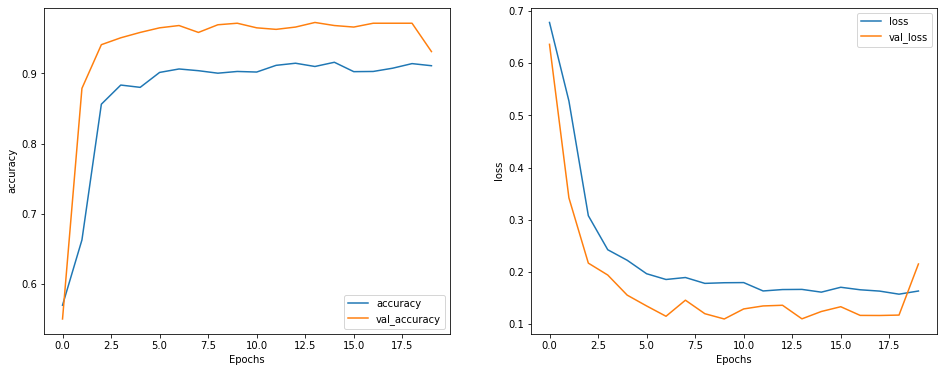

In [ ]:
import matplotlib.pyplot as plt
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

153/153 [==============================] - 11s 52ms/step - loss: 0.1128 - accuracy: 0.9598
0.9633347988128662


In [ ]:
examples = [
  "I tested positive for corona",
  "Jake is feeling sick",
  "Jake is not feeling sick",
  "i dislike sand",
  "lets go outside, it is a good day today",
  "Trump did not test positive"
]

export_model.predict(examples)

array([[0.98571557],
       [0.98318946],
       [0.36040464],
       [0.09606201],
       [0.01226812],
       [0.03147085]], dtype=float32)

In [ ]:
model.save("RNNmodel.h5")